In [1]:
#Import the Python libraries
from pandas_datareader import data as web
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [10]:
#Get the stock tickers
tickers = ["ETH-USD", "VOO"]

In [11]:
#Assign weights for stocks
weights = np.array([0.50, 0.50])

In [12]:
#Set portfolio start date
stockStartDate = '2021-07-18'

In [13]:
#Set portfolio end date
today = datetime.today().strftime('%Y-%m-%d')

In [14]:
#Dataframe to store adjusted close price of the stock
stocks_df = pd.DataFrame()

for stock in tickers:
    stocks_df[stock] = web.DataReader(stock, data_source='yahoo', start= stockStartDate, end = today)['Adj Close']    


In [15]:
#Review dataframe
stocks_df.head()

,ETH-USD,VOO
Date,,
2021-07-18,1895.552124,NaN
2021-07-19,1817.296631,389.402924
2021-07-20,1787.510742,394.904907
2021-07-21,1990.970825,398.223999
2021-07-22,2025.202759,399.071228


In [16]:
#Review dataframe
stocks_df.tail()


,ETH-USD,VOO
Date,,
2021-11-14,4626.358887,NaN
2021-11-15,4557.503906,429.769989
2021-11-16,4216.365234,431.410004
2021-11-17,4287.593750,430.369995
2021-11-19,4013.045654,NaN


In [17]:
#Create daily returns DF
daily_returns_df = stocks_df.pct_change()
daily_returns_df

,ETH-USD,VOO
Date,,
2021-07-18,NaN,NaN
2021-07-19,-0.041284,NaN
2021-07-20,-0.016390,0.014129
2021-07-21,0.113823,0.008405
2021-07-22,0.017194,0.002128
...,...,...
2021-11-14,-0.005396,0.000000
2021-11-15,-0.014883,0.000466
2021-11-16,-0.074852,0.003816


<AxesSubplot:title={'center':'Density Plot for Daily Returns'}, ylabel='Density'>

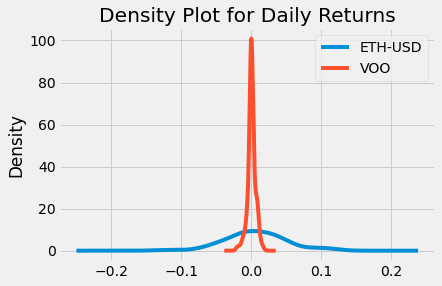

In [18]:
#Plot density curves for the portfolio
daily_returns_df.plot.density(title="Density Plot for Daily Returns")

In [19]:
#Generate the annualized covariance matrix
annual_cov_matrix = daily_returns_df.cov() * 252
annual_cov_matrix

,ETH-USD,VOO
ETH-USD,0.471847,0.022720
VOO,0.022720,0.007763


In [20]:
#Generate the Portfolio Variance
portfolio_variance = np.dot(weights.T, np.dot(annual_cov_matrix, weights))
portfolio_variance

0.13126268591010995

In [22]:
#Generate the Risk MAtrix (Std. Deviation OR Volatility)
portfolio_volatility = np.sqrt(portfolio_variance)
portfolio_variance

0.13126268591010995

In [23]:
#Calculate the Annual Portfolio Return
annual_portfolio_return = np.sum(daily_returns_df.mean() * weights) * 252
annual_portfolio_return

0.9923392617364418

In [24]:
#Display Expected Annual Return, Volatility (Risk) &  Variance
percent_variance = str(round(portfolio_variance, 2) * 100) + '%'
percent_volatility = str(round(portfolio_volatility, 2) * 100) + '%'
percent_returns = str(round(annual_portfolio_return, 2) * 100) + '%'

print('Expected Annual Return: '+ percent_returns)
print('Annual Volatility: '+ percent_volatility)
print('Annual Variance: '+ percent_variance)

Expected Annual Return: 99.0%
Annual Volatility: 36.0%
Annual Variance: 13.0%


In [25]:
#Import libraries from PyPortfolioOpt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
#Import modules for plotting
import copy
from pypfopt import risk_models, exceptions
from pypfopt import EfficientFrontier, CLA
from pypfopt import plotting
import scipy.cluster.hierarchy as sch
import warnings

In [26]:
#Portfolio Optimization for Max Sharpe Ratio
#Calculate he expected returs, annualized sample covarinace matrix of asset returns
mu = expected_returns.mean_historical_return(stocks_df)
S = risk_models.sample_cov(stocks_df)

#Optimize for the max Sharpe Ratio
ef = EfficientFrontier(mu, S)
ef.add_constraint(lambda w: sum(w[0:]) == 1)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()

print(cleaned_weights)
ef.portfolio_performance(verbose = True)

OrderedDict([('ETH-USD', 0.588), ('VOO', 0.412)])
Expected annual return: 224.0%
Annual volatility: 41.9%
Sharpe Ratio: 5.30


(2.240201869373184, 0.4188818538306251, 5.300305680634527)

In [27]:
#Get the Discrete Allocation  of each share per stock
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

latest_prices = get_latest_prices(stocks_df)
weights = cleaned_weights

da = DiscreteAllocation(weights, latest_prices, total_portfolio_value= 1000000)

allocation, leftover = da.lp_portfolio()

print('Discrete Allocation:', allocation)
print('Funds Balance: ${:.2f}'. format(leftover))

Discrete Allocation: {'ETH-USD': 146, 'VOO': 958}
Funds Balance: $1800.88


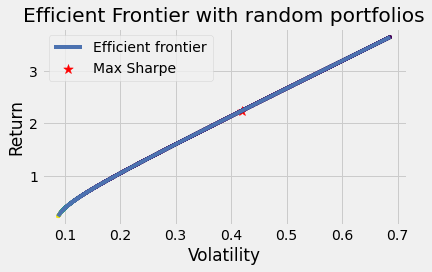

In [28]:
#Plot the Markov Efficient Frontier for Max Sharpe
#Portfolio Optimization
#Calculate he expected returns, annualized sample covarinace matrix of asset returns
mu = expected_returns.mean_historical_return(stocks_df)
S = risk_models.sample_cov(stocks_df)

#Optimize for the max Sharpe Ratio
ef = EfficientFrontier(mu, S)
ef.add_constraint(lambda w: sum(w[0:]) == 1)

#Plot instance 
fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

#Find the Tangency Portfolio
ef.max_sharpe()
ret_tangent, std_tangent, _ = ef.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")


# Generate random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets = w.dot(mu)
stds = np.sqrt(np.diag(w @ S @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Output
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.savefig("ef_scatter.png", dpi=200)
plt.show()

In [29]:
#Get the Discrete Allocation  of each share per stock (Efficient Risk; Volatility =  27.5%)
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

latest_prices = get_latest_prices(stocks_df)
weights = cleaned_weights

da = DiscreteAllocation(weights, latest_prices, total_portfolio_value= 1000000)

allocation, leftover = da.lp_portfolio()

print('Discrete Allocation:', allocation)
print('Funds Balance: ${:.2f}'. format(leftover))

Discrete Allocation: {'ETH-USD': 146, 'VOO': 958}
Funds Balance: $1800.88


## Optimize Portfolio for Min. Risk (Volatility)

In [30]:
#Portfolio Optimization
#Calculate he expected returs, annualized sample covarinace matrix of asset returns
mu = expected_returns.mean_historical_return(stocks_df)
S = risk_models.sample_cov(stocks_df)

#Optimize for the max Sharpe Ratio
ef = EfficientFrontier(mu, S)
weights = ef.min_volatility()
cleaned_weights = ef.clean_weights()

ef.save_weights_to_file("weights.txt")  # saves to file
print(cleaned_weights)

OrderedDict([('ETH-USD', 0.0), ('VOO', 1.0)])


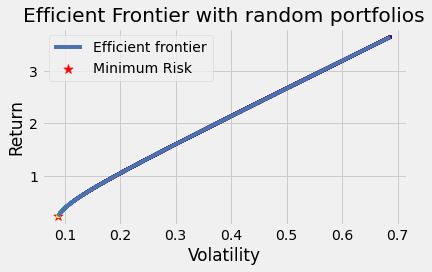

In [31]:
# Plot the Markov Efficient Frontier for Min. Risk (Volatility)
#Portfolio Optimization
#Calculate he expected returns, annualized sample covarinace matrix of asset returns
mu = expected_returns.mean_historical_return(stocks_df)
S = risk_models.sample_cov(stocks_df)

#Optimize for the minimum risk (volatility)
ef = EfficientFrontier(mu, S)
ef.add_constraint(lambda w: sum(w[0:]) == 1)

#Plot instance 
fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

#Find the Tangency Portfolio
ef.min_volatility()
ret_tangent, std_tangent, _ = ef.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Minimum Risk")


# Generate random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets = w.dot(mu)
stds = np.sqrt(np.diag(w @ S @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Output
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.savefig("ef_scatter.png", dpi=200)
plt.show()

In [32]:
#Get the Discrete Allocation  of each share per stock
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

latest_prices = get_latest_prices(stocks_df)
weights = cleaned_weights

da = DiscreteAllocation(weights, latest_prices, total_portfolio_value= 1000000)

allocation, leftover = da.lp_portfolio()

print('Discrete Allocation:', allocation)
print('Funds Balance: ${:.2f}'. format(leftover))

Discrete Allocation: {'VOO': 2323}
Funds Balance: $250.50


## Optimize portfolio for Efficient Risk (Volatility = 30%)

In [33]:
#Portfolio Optimization
#Calculate he expected returs, annualized sample covarinace matrix of asset returns
mu = expected_returns.mean_historical_return(stocks_df)
S = risk_models.sample_cov(stocks_df)

#Optimize for the max Sharpe Ratio
ef = EfficientFrontier(mu, S)
weights = ef.efficient_risk(0.275)
cleaned_weights = ef.clean_weights()

ef.save_weights_to_file("weights.txt")  # saves to file
print(cleaned_weights)

OrderedDict([('ETH-USD', 0.3624), ('VOO', 0.6376)])


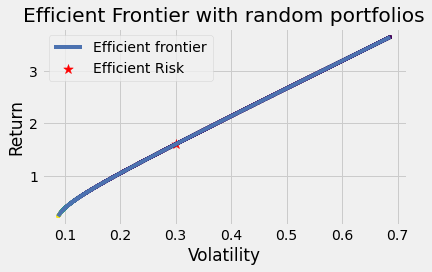

In [34]:
#Asset clasifcation for Efficient Risk Portfolio
# Plot the Markov Efficient Frontier for Efficient Risk
#Portfolio Optimization
#Calculate he expected returns, annualized sample covarinace matrix of asset returns
mu = expected_returns.mean_historical_return(stocks_df)
S = risk_models.sample_cov(stocks_df)

#Optimize for the Efficient Risk
ef = EfficientFrontier(mu, S)
ef.add_constraint(lambda w: sum(w[0:]) == 1)

#Plot instance 
fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

#Find the Tangency Portfolio

ef.efficient_risk(0.30)
ret_tangent, std_tangent, _ = ef.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Efficient Risk")


# Generate random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets = w.dot(mu)
stds = np.sqrt(np.diag(w @ S @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Output
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.savefig("ef_scatter.png", dpi=200)
plt.show()

In [35]:
#Get the Discrete Allocation  of each share per stock (Efficient Risk; Volatility =  30%
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

latest_prices = get_latest_prices(stocks_df)
weights = cleaned_weights

da = DiscreteAllocation(weights, latest_prices, total_portfolio_value= 1000000)

allocation, leftover = da.lp_portfolio()

print('Discrete Allocation:', allocation)
print('Funds Balance: ${:.2f}'. format(leftover))

Discrete Allocation: {'ETH-USD': 90, 'VOO': 1482}
Funds Balance: $1017.56
